In [98]:
from __future__ import print_function
import numpy as np # Biblioteca de funciones matematicas de alto nivel
np.random.seed(1337)  # for reproducibility
import tensorflow as tf
import keras  
import pandas

In [100]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8497156257834180327
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1764950016
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15628625470256144882
physical_device_desc: "device: 0, name: A100-PCIE-40GB MIG 1g.5gb, pci bus id: 0000:17:00.0, compute capability: 8.0"
]


In [108]:
nvidia-smi

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: A100-PCIE-40GB MIG 1g.5gb, pci bus id: 0000:17:00.0, compute capability: 8.0



AttributeError: module 'tensorflow' has no attribute 'list_devices'

In [61]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
session = InteractiveSession.close

/opt/conda/lib/python3.8/site-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [62]:
from keras.preprocessing import sequence
from keras.models import Sequential # necesario para poder generar la red neuronal
from keras.layers import Dense, Dropout, Activation, Lambda # Tipos de capa, hacen lo siguiente:
from keras.layers import Embedding
from keras.layers import Convolution1D,MaxPooling1D, Flatten, LSTM
from keras.callbacks import CSVLogger # para guardar los datos en un excel
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

In [63]:
from keras.datasets import imdb # un dataset incluido en keras
from keras import backend as K # importas el backend (Tensorflow, Theano, etc)
import pandas as pd # pandas es una libreria extension de numpy usada para manipulacion y analisis de datos, para manipular tablas numericas y series temporales
from keras.utils.np_utils import to_categorical # sirve para convertir vectores de enteros a una matriz de clases binaria
import h5py # para almacenar un monton de datos numericos y dar facilidades de manipulacion para datos de Numpy
from sklearn.preprocessing import Normalizer # Para normalizar los datos
from sklearn.model_selection import train_test_split #para hacer la separacion entre datos de test y train
from sklearn.preprocessing import OneHotEncoder #para convertir los datos de entrada

In [64]:
dataset = pd.read_csv('Datasets/Train.csv', encoding = "ISO-8859-1") # lectura de datos
dataset1 = pd.read_csv('Datasets/Test.csv', encoding = "ISO-8859-1") # lectura de datos

In [65]:
dataset.shape
# Replacing infinite and nan para evitar errores
dataset.replace([np.inf, -np.inf], -1, inplace=True) 
dataset.replace([np.nan, -np.nan], -1, inplace=True)

In [66]:
dataset.shape
# Replacing infinite and nan para evitar errores
dataset1.replace([np.inf, -np.inf], -1, inplace=True) 
dataset1.replace([np.nan, -np.nan], -1, inplace=True)

In [67]:
#Eliminamos los datos mal introducidos
dataset = dataset.drop(dataset[dataset['Dst Port']=='Dst Port'].index)
#Eliminamos las columnas innecesarias
dataset = dataset.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP','Unnamed: 0','Dst Port'], axis=1)
#Quitamos direcciones IP dest y src para no introducir sesgos, lo mismo con los puertos
#Quitar el puerto de destino es una modificación con respecto al trabajo original
#Eliminamos la columna de timestamp para no tener sesgo
dataset = dataset.drop(['Timestamp'], axis=1)

In [68]:
#Eliminamos los datos mal introducidos
dataset1 = dataset1.drop(dataset1[dataset1['Dst Port']=='Dst Port'].index)
#Eliminamos las columnas innecesarias
dataset1 = dataset1.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP','Unnamed: 0','Dst Port'], axis=1)
#Quitamos direcciones IP dest y src para no introducir sesgos, lo mismo con los puertos
#Quitar el puerto de destino es una modificación con respecto al trabajo original
#Eliminamos la columna de timestamp para no tener sesgo
dataset1 = dataset1.drop(['Timestamp'], axis=1)

In [69]:
dataset1

,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6,497,2,0,22.0,0.0,22.0,0.0,11.00,15.556349,...,32,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,FTP-BruteForce
1,6,312,2,0,79.0,0.0,79.0,0.0,39.50,55.861436,...,32,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,FTP-BruteForce
2,6,591,2,0,22.0,0.0,22.0,0.0,11.00,15.556349,...,32,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,FTP-BruteForce
3,6,778,2,0,22.0,0.0,22.0,0.0,11.00,15.556349,...,32,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,FTP-BruteForce
4,6,1261,2,0,22.0,0.0,22.0,0.0,11.00,15.556349,...,32,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,FTP-BruteForce
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101987,17,5969,8,0,2470.0,0.0,346.0,272.0,308.75,34.849677,...,8,0,0,0,0,1.648698e+15,2.236881e+03,1.648698e+15,1.648698e+15,Benign
101988,6,95543879,5,3,638.0,850.0,635.0,0.0,127.60,283.645553,...,20,0,0,0,0,1.413170e+15,6.231494e+14,1.648698e+15,4.501241e+07,Benign
101989,0,110405676,16,0,0.0,0.0,0.0,0.0,0.00,0.000000,...,0,0,0,0,0,1.648698e+15,3.480794e+07,1.648698e+15,1.648698e+15,Benign
101990,6,90528029,3,2,3.0,0.0,1.0,1.0,1.00,0.000000,...,20,0,0,0,0,1.648698e+15,2.572177e+05,1.648698e+15,1.648698e+15,Benign


In [70]:
#Convertimos los datos a float64 para poder trabajar con ellos (menos el campo de etiquetas)
n=0
for column in dataset:
    column
    if column != 'Label':
        dataset[column] = dataset[column].astype(float)

In [71]:
#Convertimos los datos a float64 para poder trabajar con ellos (menos el campo de etiquetas)
n=0
for column in dataset1:
    column
    if column != 'Label':
        dataset1[column] = dataset1[column].astype(float)

In [72]:
#revisamos cuantos valores puede tener la ultima columna, osea, los tipos de flujo
Labels = dataset['Label'].unique()
Labels #para asignar nombres a las diferentes metricas en un futuro

array(['FTP-BruteForce', 'DoS attacks-GoldenEye', 'DoS attacks-Hulk',
       'DoS attacks-SlowHTTPTest', 'DoS attacks-Slowloris',
       'SSH-Bruteforce', 'Benign'], dtype=object)

In [73]:
#revisamos cuantos valores puede tener la ultima columna, osea, los tipos de flujo
Labels1 = dataset1['Label'].unique()
Labels1 #para asignar nombres a las diferentes metricas en un futuro

array(['FTP-BruteForce', 'DoS attacks-GoldenEye', 'DoS attacks-Hulk',
       'DoS attacks-SlowHTTPTest', 'DoS attacks-Slowloris',
       'SSH-Bruteforce', 'Benign'], dtype=object)

In [74]:
Y_train = dataset["Label"]

In [75]:
Y_test = dataset1["Label"]

In [76]:
#Ahora que hemos conseguido transformar estas columnas a numeros, podemos empezar con la red neuronal
#Necesitamos un grupo de train y otro de test para la red neuronal, los crearemos con train_test_split
X_train=dataset.iloc[:, 0:77] #Luego obtenemos las características del flujo
X_test=dataset1.iloc[:, 0:77]

In [96]:
# from sklearn.preprocessing import LabelEncoder #Para pasar a numeros
# lb_make = LabelEncoder()
# lb_make.fit_transform(Labels)
# Y=lb_make.transform(Y)                         #Transformamos las etiquetas a números según las clases definidas

from sklearn.preprocessing import LabelEncoder #para pasar a numeros
lb_make = LabelEncoder()
Y_train = lb_make.fit_transform(Y_train)
Y_train

LabelEncoder()

In [78]:
# from sklearn.preprocessing import LabelEncoder #Para pasar a numeros
# lb_make = LabelEncoder()
# lb_make.fit_transform(Labels)
# Y=lb_make.transform(Y)                         #Transformamos las etiquetas a números según las clases definidas

from sklearn.preprocessing import LabelEncoder #para pasar a numeros
lb_make = LabelEncoder()
Y_test = lb_make.fit_transform(Y_test)
Y_test

array([5, 5, 5, ..., 0, 0, 0])

In [79]:
Labels = lb_make.inverse_transform(Y_train)
Labels = list(lb_make.classes_)
Labels

['Benign',
 'DoS attacks-GoldenEye',
 'DoS attacks-Hulk',
 'DoS attacks-SlowHTTPTest',
 'DoS attacks-Slowloris',
 'FTP-BruteForce',
 'SSH-Bruteforce']

In [80]:
Labels1 = lb_make.inverse_transform(Y_test)
Labels1 = list(lb_make.classes_)
Labels1

['Benign',
 'DoS attacks-GoldenEye',
 'DoS attacks-Hulk',
 'DoS attacks-SlowHTTPTest',
 'DoS attacks-Slowloris',
 'FTP-BruteForce',
 'SSH-Bruteforce']

In [81]:
dataset["Label"].value_counts()

Benign                      121679
DoS attacks-Slowloris        53877
DoS attacks-SlowHTTPTest     53850
DoS attacks-GoldenEye        52179
FTP-BruteForce               50894
DoS attacks-Hulk             50689
SSH-Bruteforce               46988
Name: Label, dtype: int64

In [82]:
dataset1["Label"].value_counts()

Benign                      32391
FTP-BruteForce              15138
SSH-Bruteforce              11965
DoS attacks-SlowHTTPTest    11110
DoS attacks-Slowloris       11109
DoS attacks-Hulk            10257
DoS attacks-GoldenEye       10022
Name: Label, dtype: int64

In [83]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(X_train) # Normalizamos los datos
trainX = scaler.transform(X_train) # Asi se representan los datos

#scaler = MinMaxScaler().fit(X_test)
testT = scaler.transform(X_test)

y_train1 = np.array(Y_train) # sirve para crear un array en numpy
y_test1 = np.array(Y_test)


y_train= to_categorical(y_train1,len(Labels)) # Para convertir los datos a multiclase
y_test= to_categorical(y_test1,len(Labels1))  
# y_train= to_categorical(y_train1) # para convertir los datos a clase binaria
# y_test= to_categorical(y_test1)

In [84]:
# reshape input to be [samples, time steps, features]
# reshape input to be [samples, time steps, features]
X_train = np.reshape(trainX, (trainX.shape[0],trainX.shape[1],1))
X_test = np.reshape(testT, (testT.shape[0],testT.shape[1],1))

In [85]:
#creamos la red neuronal
model = Sequential()
model.add(Convolution1D(64, 3, activation="relu",input_shape=(77, 1), padding = 'same'))
#Al quitar el puerto de destino el tamaño de la red neuronal cambia de 78 a 77 (menos características)
#######
#   Añadimos la primera capa de Convolution1D, los diferentes parametros indican lo siguiente:
#       64 --> numero de filtros
#       3 --> tamaño del filtro (3,1)
#       border_mode = "same" --> este parametro sirve para que el output sea del mismo tamaño que el input
#       activation = "relu" --> Tipo de funcion de activacion de neuronas que vamos a usar
#       input_shape = (78, 1) --> tamaño de la entrada, hay 77 features (quitamos timestamp y dst port con respecto a original)
#######
model.add(Convolution1D(64, 3, activation="relu", padding = 'same'))
model.add(MaxPooling1D(pool_size=(2))) # capa donde se lleva a cabo el pooling, se queda con el maximo de cada 2
model.add(Convolution1D(128, 3,  activation="relu", padding = 'same'))
model.add(Convolution1D(128, 3,  activation="relu", padding = 'same'))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten()) #Si eliminamos red LSTM
# model.add(LSTM(lstm_output_size)) # Se añade una LSTM como segunda red
model.add(Dropout(0.1)) 
model.add(Dense(len(Labels), activation="softmax")) # capa fully conected para decision final, usamos softmax porque con ella los valores finales tienen mas relacion con los valores
# anteriores y no solo con 1
#Al poner len(Labels) adaptamos el tamaño de capa en funcióndel 

#como evitar el overfit en redes convolucionales
#r2regularicer

In [86]:
# define optimizer and objective, compile cnn
model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=['categorical_accuracy']) # se compila la red neuronal con los siguientes parametros:
######
#   PARAMETROS:
#       loss = "categorical_crossentropy" --> esta relacionado con la funcion softmax, se usa para dar una probabilidad sobre unas clases
#       optimizer = "adam" --> Stochastic gradient descent
#       metrics = 'accuracy' --> compara los resultados finales con los reales y de ahi saca las estadisticas
######

In [87]:
#Para ello introducimos el código necesario
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath="ResultadosRedes/Checkpoints_sin/checkpoint-{epoch:02d}.hdf5", verbose=1, save_best_only=True, monitor='categorical_accuracy',mode='max')
######
#   ModelCheckpoint se usa para guardar datos o pesos en algun momento de forma que estos puedan ser cargados o examinados en un futuro
#   PARAMETROS:
#       filepath --> direccion donde se va a guardar el archivo
#       verbose = 1 --> para ver una barra de progreso de la operacion
#       save_best_only = True --> se guarda solo si los datos son mejores que los anteriores, en este caso como la metrica de evaluacion de la red es accuracy se mide con eso
#       monitor --> lo que hay que monitorear
#       mode --> segun este parametro se tomara la decision de cuando sobreescribir y cuando no, en este caso como esta indicado max, se sobreescribe cuando el valor de monitor es mayor
######

In [88]:
csv_logger = CSVLogger('ResultadosRedes/modeltrainanalysis15epochs_sin.csv',separator=',', append=False)
######
#   CSVLogger sirve para guardar los datos en un fichero CSV
#   PARAMETROS:
#       filename --> nombre y direccion del archivo
#       separator --> como se separan los resultados en el csv
#       append = false --> con esta opcion se sobreescribe lo que hubiese en el archivo destino, si fuese "True" se concatenaria
######

In [89]:
model.fit(X_train, y_train, epochs=100,callbacks=[checkpointer,csv_logger])
######
#   cnn.fit es la  instruccion con la que se entrena la red neuronal
######
model.save("ResultadosRedes/saved_model_sin.hdf5")

Epoch 1/100
13443/13443 [==============================] - 119s 9ms/step - loss: 0.1725 - categorical_accuracy: 0.9412

Epoch 00001: categorical_accuracy improved from -inf to 0.96599, saving model to ResultadosRedes/Checkpoints_sin/checkpoint-01.hdf5
Epoch 2/100
13443/13443 [==============================] - 117s 9ms/step - loss: 0.0566 - categorical_accuracy: 0.9809

Epoch 00002: categorical_accuracy improved from 0.96599 to 0.98198, saving model to ResultadosRedes/Checkpoints_sin/checkpoint-02.hdf5
Epoch 3/100
13443/13443 [==============================] - 117s 9ms/step - loss: 0.0482 - categorical_accuracy: 0.9830

Epoch 00003: categorical_accuracy improved from 0.98198 to 0.98322, saving model to ResultadosRedes/Checkpoints_sin/checkpoint-03.hdf5
Epoch 4/100
13443/13443 [==============================] - ETA: 0s - loss: 0.0455 - categorical_accuracy: 0.98 - 118s 9ms/step - loss: 0.0455 - categorical_accuracy: 0.9838

Epoch 00004: categorical_accuracy improved from 0.98322 to 0.983

In [90]:
#Cargamos los resultados obtenidos en la etapa de train
model.load_weights("ResultadosRedes/saved_model_sin.hdf5")

#predecimos la naturaleza de los paquetes de test
# y_pred = (model.predict(X_test) > 0.5).astype("int32") #Para cuando es binario
y_pred=np.argmax(model.predict(X_test), axis=-1) #Para cuando es multiclase

loss, categorical_accuracy = model.evaluate(X_test, y_test)
print("\nLoss: %.2f, Accuracy: %.3f%%" % (loss, categorical_accuracy*100))

3188/3188 [==============================] - 19s 6ms/step - loss: 0.2587 - categorical_accuracy: 0.9836

Loss: 0.26, Accuracy: 98.359%


In [91]:
Labels = np.array(Labels)
Labels

array(['Benign', 'DoS attacks-GoldenEye', 'DoS attacks-Hulk',
       'DoS attacks-SlowHTTPTest', 'DoS attacks-Slowloris',
       'FTP-BruteForce', 'SSH-Bruteforce'], dtype='<U24')

In [92]:
y_test1_text = []
for i in range(0, y_test1.size):
    for j in range(0, Labels.size):
        if y_test1[i] == j:
            y_test1_text.append(Labels[j])

In [93]:
y_pred_text = []
for i in range(0, y_pred.size):
    for j in range(0, Labels.size):
        if y_pred[i] == j:
            y_pred_text.append(Labels[j])

In [94]:
from sklearn.metrics import classification_report

print(classification_report(y_test1_text, y_pred_text, digits=8, zero_division= "warn"))

                          precision    recall  f1-score   support

                  Benign  0.99984557 0.99941342 0.99962945     32391
   DoS attacks-GoldenEye  0.98252327 0.94801437 0.96496039     10022
        DoS attacks-Hulk  0.94873998 0.96899678 0.95876139     10257
DoS attacks-SlowHTTPTest  0.97109881 0.93150315 0.95088896     11110
   DoS attacks-Slowloris  0.94531650 0.99747952 0.97069774     11109
          FTP-BruteForce  0.99986783 0.99947153 0.99966964     15138
          SSH-Bruteforce  0.99899649 0.99841204 0.99870418     11965

                accuracy                      0.98358695    101992
               macro avg  0.97805549 0.97761297 0.97761596    101992
            weighted avg  0.98383690 0.98358695 0.98354967    101992



<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

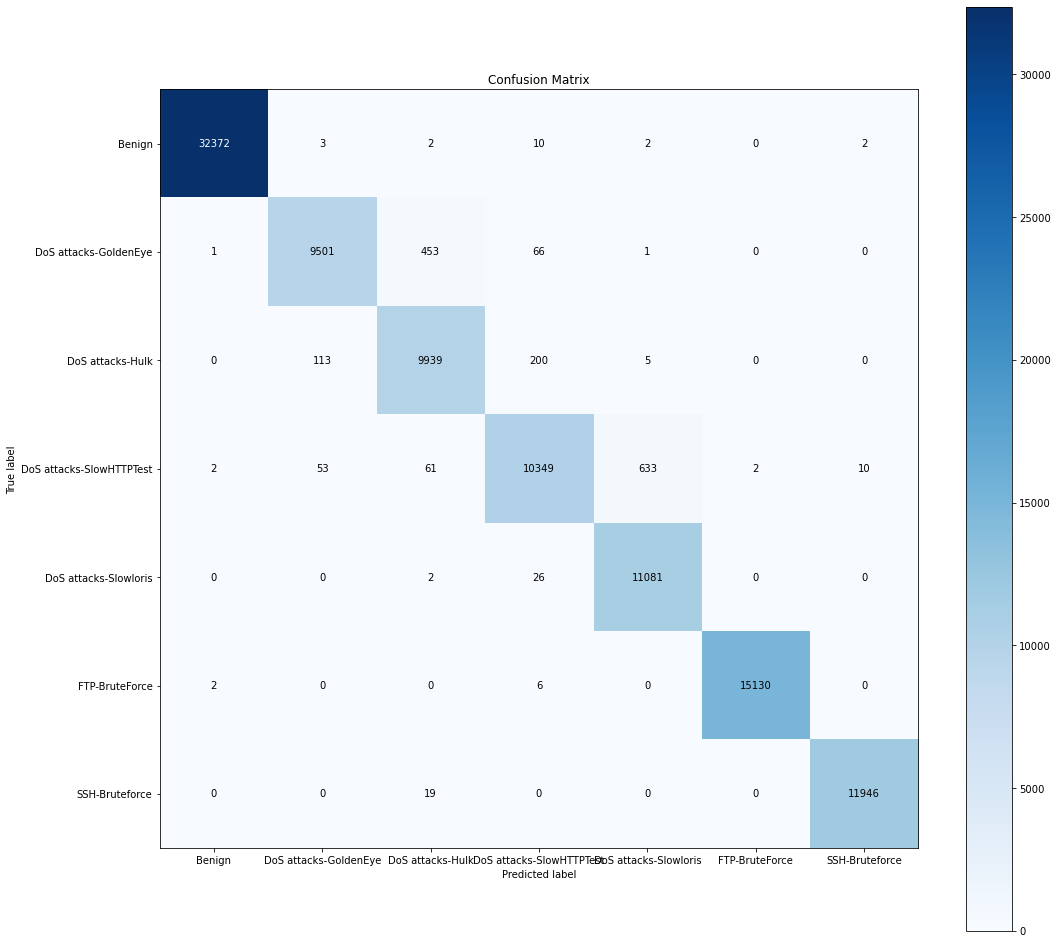

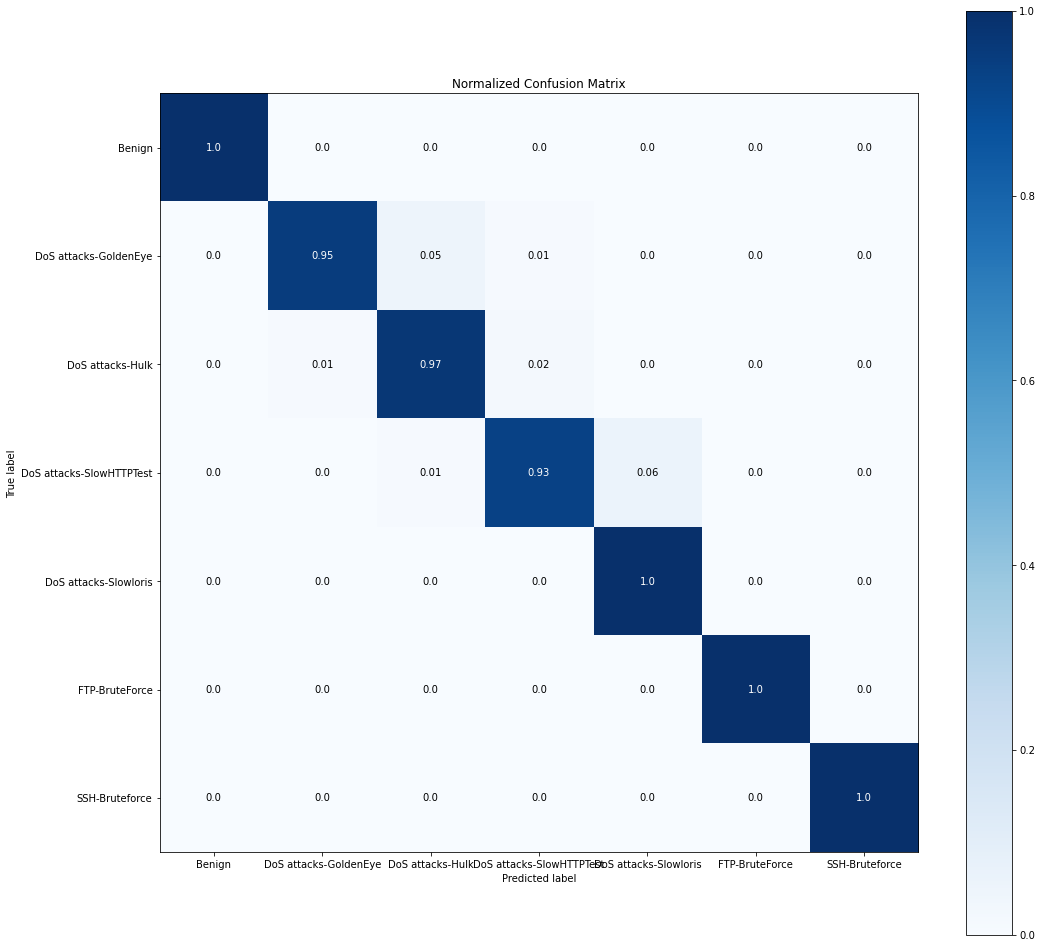

In [95]:
#!pip install scikit-plot
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(y_test1_text, y_pred_text, figsize= (17,17))
skplt.metrics.plot_confusion_matrix(y_test1_text, y_pred_text, normalize= True, figsize= (17,17))